# Lab6.4-BERT-Topic-modelling

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

## Credits

This notebook is based on Maarten Grootendorst's work:
* https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
* https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8


## Input data

20 Newsgroups dataset which contains roughly 18000 newsgroups posts on 20 topics

In [1]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

If you want to speed up training, you can select the subset train as it will decrease the number of posts you extract.

# Sentence embeddings for DistilBERT

In [3]:
# pip install sentence-transformers 

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

100%|██████████| 245M/245M [00:22<00:00, 11.1MB/s] 


In [12]:
import pandas as pd
docs_df = pd.DataFrame(data, columns=["Doc"])

In [13]:
docs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Doc     18846 non-null  object
dtypes: object(1)
memory usage: 147.4+ KB


In [14]:
docs_df.head()

,Doc
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...


## Dimensionality reduction using UMAP

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [16]:
# %pip uninstall umap
# %pip install umap-learn 

     |████████████████████████████████| 69 kB 3.8 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67950 sha256=a0e3c09a93248714e46bcc13378bff3ae685a23455700456a4f51031ee37c789
  Stored in directory: /Users/piek/Library/Caches/pip/wheels/14/9a/ed/66159a5e13d3b6341b6542cf4f1faf478834753bed5ecaef8d
Successfully built umap-learn
You should consider upgrading via the '/Users/piek/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [31]:
#import umap
import umap.umap_ as umap
reducer = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')

In [32]:
umap_embeddings = reducer.fit_transform(embeddings)

## Clusering using HDBSCAN

In [33]:
#%pip install hdbscan

You should consider upgrading via the '/Users/piek/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [35]:
## Visualise the clusters

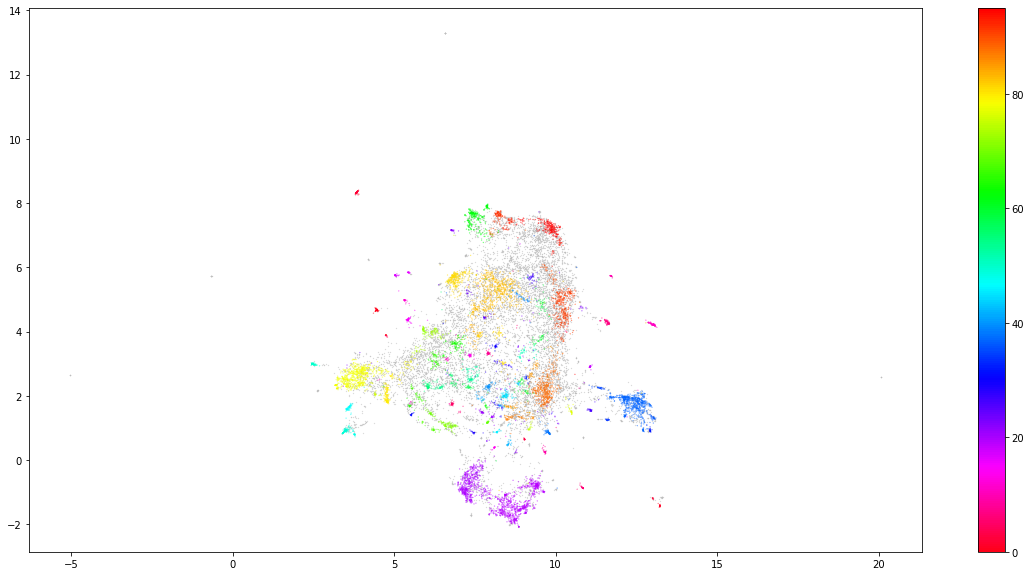

In [36]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

## Words representing topic clusers using c-TF-IDF

### Calculating TF-IDF

In [37]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


### Applying c-TF-IDF

In [38]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

### Representing each topic by its top scoring words

In [39]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,10356
20,19,796
38,37,649
79,78,645
84,83,612
21,20,555
89,88,424
92,91,347
82,81,327
63,62,278


In [40]:
top_n_words[7][:10]

[('au', 0.04175436008869877),
 ('australia', 0.03166321189023938),
 ('monash', 0.02830903102392096),
 ('gamma', 0.020233630404535706),
 ('maria', 0.015422974516711612),
 ('yoyo', 0.01447658450186117),
 ('uwa', 0.013709686645883288),
 ('workspace', 0.013708407196471333),
 ('darice', 0.013533075075913283),
 ('cc', 0.011249074571214084)]

In [41]:
top_n_words[1][:10]

[('henrik', 0.09915340472248992),
 ('armenia', 0.07714507135570067),
 ('bm', 0.05636704934331142),
 ('armenians', 0.05572373894986821),
 ('planes', 0.05517134602101829),
 ('turkey', 0.04676427229865609),
 ('turkish', 0.04568797335220795),
 ('onur', 0.042659385682019296),
 ('yalcin', 0.042659385682019296),
 ('azeris', 0.04233587639438071)]

In [42]:
top_n_words[18][:10]

[('washington', 0.059187289087718344),
 ('seattle', 0.03384436867183895),
 ('carson', 0.02203105903774726),
 ('gre', 0.020616385427092414),
 ('stein', 0.019676419084973196),
 ('whitmore', 0.013119441097102032),
 ('206', 0.012261143035205618),
 ('religion', 0.01111053038018705),
 ('chicogo', 0.009898177505824453),
 ('allah', 0.009829567591043364)]

## End of this notebook